In [1]:
import sys
sys.path.append('../')
from abel import *

%load_ext autoreload
%autoreload 2

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 #10e-15 # [m]
driver.symmetrize = True

test_particle = SourceSingleParticle()
test_particle.energy = 470e9 # [eV]
test_particle.z = 0 # [m]
test_particle.x = 50e-6 # [m]
test_particle.y = 0 # [m]
test_particle.yp = 0
test_particle.xp = 0

# define stage
stage = StageHipace()
stage.driver_source = driver
stage.test_particle_source = test_particle
stage.length = 11 # [m]
stage.plasma_density = 2e21 # [m^-3]
stage.nom_energy_gain = 31.9e9/(11/stage.length) # [eV]
stage.radiation_reaction = False
stage.ion_motion = False
stage.beam_ionization=False
stage.ramp_beta_mag = 5
stage.num_nodes = 16

# define first stage (half length)
#first_stage = StageHipace()
#first_stage.driver_source = driver
#first_stage.length = stage.length/2 # [m]
#first_stage.plasma_density = 2e21 # [m^-3]
#first_stage.nom_energy_gain = stage.nom_energy_gain/2 # [eV]
#first_stage.radiation_reaction = stage.radiation_reaction

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = test_particle.energy # [eV]
source.rel_energy_spread = 0.01
source.bunch_length = 28e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
source.jitter.t = driver.jitter.t

# define interstage
interstage = InterstageBasic()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1 # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
#linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 1

shots = 1

In [3]:
name = f'linac_hipace_test_particle_{int(source.energy/1e9)}GeV_\
{interstage.dipole_field}T_ex_{source.emit_nx*1e6}_jitterx_{driver.jitter.x}_\
jittery_{driver.jitter.y}_RR_{stage.radiation_reaction}N_{linac.num_stages}_11m_{shots}_shot\
_{source.num_particles}_particles\
inits_z{test_particle.z*1e6}_x{test_particle.x*1e6}_y{test_particle.y*1e6}\
_xp{test_particle.xp*1e6}_yp{test_particle.z*1e6}'

linac.run(name, num_shots=shots, overwrite=False, parallel=False);

>> SHOT 1 already exists and will not be overwritten.


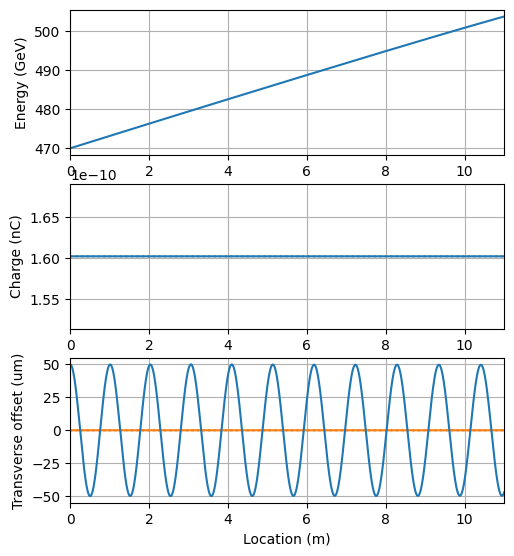

In [4]:
stage_evolution = linac.stages[0].plot_test_particle_evolution()

In [5]:
save = False
if save:
    stage_evolution.savefig(f'Plots_with_updated_params/Hipace_test_particle_stage_evolution_\
    {shots}_shots_{int(source.energy/1e9)}GeV_{int(source.emit_nx*1e6)}\
    mmmrad_{int(source.emit_ny*1e6)}\
    mmmrad_{interstage.dipole_field}T_RR_{stage.radiation_reaction}_\
    B_{interstage.dipole_field}T_11m_{source.num_particles}_particles\
    inits_z{test_particle.z*1e6}_x{test_particle.x*1e6}_y{test_particle.y*1e6}\
    _xp{test_particle.xp*1e6}_yp{test_particle.z*1e6}.png')

In [14]:
E_noRR = linac.stages[0].test_particle_evolution.energy/1e9

In [7]:
stage.radiation_reaction = True
linac2 = Linac()
linac2.source = source
linac2.stage = stage
#lina2c.first_stage = first_stage
linac2.interstage = interstage
linac2.num_stages = 1

In [8]:
name = f'linac_hipace_test_particle_{int(source.energy/1e9)}GeV_\
{interstage.dipole_field}T_ex_{source.emit_nx*1e6}_jitterx_{driver.jitter.x}_\
jittery_{driver.jitter.y}_RR_{stage.radiation_reaction}N_{linac.num_stages}_11m_{shots}_shot\
_{source.num_particles}_particles\
inits_z{test_particle.z*1e6}_x{test_particle.x*1e6}_y{test_particle.y*1e6}\
_xp{test_particle.xp*1e6}_yp{test_particle.z*1e6}'

linac2.run(name, num_shots=shots, overwrite=False, parallel=False);

>> SHOT 1 already exists and will not be overwritten.


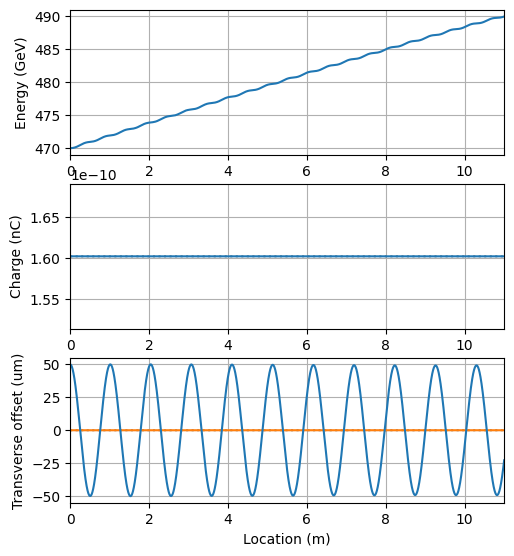

In [9]:
stage_evolution = linac2.stages[0].plot_test_particle_evolution()

In [15]:
E_RR = linac2.stages[0].test_particle_evolution.energy/1e9

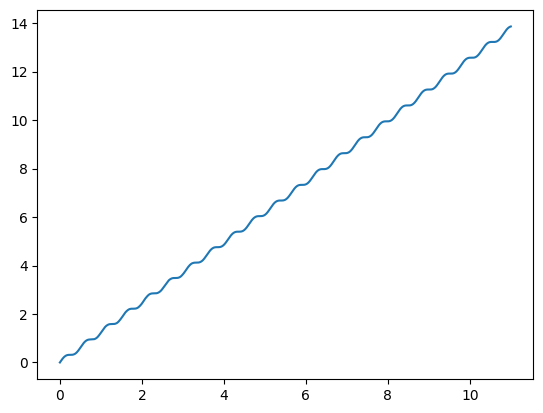

In [16]:
P = E_noRR - E_RR
zs = linac.stages[0].test_particle_evolution.location
plt.plot(zs, P)